# Data Preprocessing Plot/Data

Used by B.A.K. to finalize the plotting and data saving methods, find the best values of different threshold and parameters.

The discoveries made here were integrated into the python script(plot_data.py) that looped over all recordings and generated all plots at once.

Once the plots were used for manual labelling, the resulting data was saved using that script, modified.

Notes:

The offset is used because of the relatively high silence threshold: it is "triggered" only about quarter of the way through vocalisations, meaning that without this offset, the generated sequences only include vocalisations that are cut in half.


In [1]:
import os
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf

In [2]:
def get_time(index, samplerate=24000):
    s_idx = index / samplerate
    hours = s_idx // 3600
    minutes = int((s_idx - hours*3600) // 60)
    seconds = (s_idx - hours*3600 - minutes * 60)
    return [minutes, seconds]

In [3]:
files = {
3:'2018-08-14/b8p2male-b10o15female_3_SdrChannels.w64',
5:'2018-08-14/b8p2male-b10o15female_5_SdrChannels.w64',
6:'2018-08-14/b8p2male-b10o15female_6_SdrChannels.w64',
8:'2018-08-14/b8p2male-b10o15female_8_SdrChannels.w64',
9:'2018-08-14/b8p2male-b10o15female_9_SdrChannels.w64',
10:'2018-08-14/b8p2male-b10o15female_10_SdrChannels.w64',
11:'2018-08-14/b8p2male-b10o15female_11_SdrChannels.w64',
12:'2018-08-14/b8p2male-b10o15female_12_SdrChannels.w64',
14:'2018-08-14/b8p2male-b10o15female_14_SdrChannels.w64',
15:'2018-08-14/b8p2male-b10o15female_15_SdrChannels.w64',
17:'2018-08-14/b8p2male-b10o15female_17_SdrChannels.w64',
18:'2018-08-14/b8p2male-b10o15female_18_SdrChannels.w64',
19:'2018-08-14/b8p2male-b10o15female_19_SdrChannels.w64',
20:'2018-08-15/b8p2male-b10o15female_20_SdrChannels.w64',
27:'2018-08-15/b8p2male-b10o15female_27_SdrChannels.w64',
28:'2018-08-16/b8p2male-b10o15female_28_SdrChannels.w64',
29:'2018-08-16/b8p2male-b10o15female_29_SdrChannels.w64',
30:'2018-08-16/b8p2male-b10o15female_30_SdrChannels.w64',
31:'2018-08-16/b8p2male-b10o15female_31_SdrChannels.w64',
31:'2018-08-16/b8p2male-b10o15female_32_SdrChannels.w64',
33:'2018-08-16/b8p2male-b10o15female_33_SdrChannels.w64',
43:'2018-08-18/b8p2male-b10o15female_43_SdrChannels.w64',
44:'2018-08-18/b8p2male-b10o15female_44_SdrChannels.w64',
45:'2018-08-18/b8p2male-b10o15female_45_SdrChannels.w64',
46:'2018-08-18/b8p2male-b10o15female_46_SdrChannels.w64',
47:'2018-08-18/b8p2male-b10o15female_47_SdrChannels.w64',
48:'2018-08-19/b8p2male-b10o15female_48_SdrChannels.w64',
49:'2018-08-19/b8p2male-b10o15female_49_SdrChannels.w64',
50:'2018-08-19/b8p2male-b10o15female_50_SdrChannels.w64',
51:'2018-08-19/b8p2male-b10o15female_51_SdrChannels.w64',
52:'2018-08-19/b8p2male-b10o15female_52_SdrChannels.w64',
53:'2018-08-19/b8p2male-b10o15female_53_SdrChannels.w64'
}
def read_recording(no, names=files):
    '''
    Returns Recording in format
    mic, acc_m, acc_f
    '''
    try:
        file = '/home/bukaya/ethz/ns/b8p2male-b10o15female_aligned/' + files[no]
        with open(file, 'rb') as f:  
            Audiodata, _samplerate_bad = sf.read(f)
        mic   = Audiodata[:, 0]
        acc_m = Audiodata[:, 1]
        acc_f = Audiodata[:, 2]
        del Audiodata
        return mic, acc_m, acc_f
    except KeyError:
        print(f'Recording {no} does not exist.\nTry any of: {files.keys()}')
        return 0, 0, 0

In [4]:
if not os.path.exists('data'):
    os.makedirs('data')

if not os.path.exists('plot'):
    os.makedirs('plot')

fs = 24000
window_size = 256
overlap = 0.875
noverlap = int(np.floor(window_size * overlap))

no = 11

mic, acc_m, acc_f = read_recording(no)

In [5]:
# Apply bandpass
sos = signal.butter(10, [15, 8000], 'bp', fs=24000, output='sos')
filtered_bp = signal.sosfilt(sos, mic)
#sf.write('/home/bukaya/ethz/ns/vocal-recon/mic11_butterworth_bp_10_15_8000.w64', filtered_bp, fs)

In [6]:
acc_m_bp = signal.sosfilt(sos, acc_m)

In [7]:
acc_f_bp = signal.sosfilt(sos, acc_f)

In [ ]:
# clear memory
del mic
del acc_m
del acc_f
del sos

In [8]:
# Take moving window RMS
window = 2400
sq_fil = np.power(filtered_bp,2)
mean_pd_abs = pd.Series(sq_fil).rolling(window=window).mean().iloc[window-1:].values
#del sq_fil

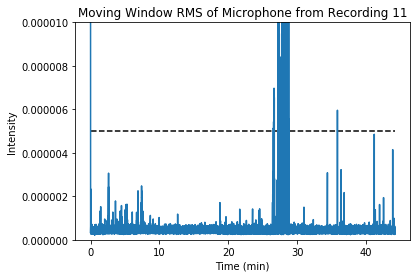

In [24]:
# Plot to choose threshold for silence (do this rarely, takes some seconds)
plt.plot(mean_pd_abs)
plt.ylim([0, 10e-6])
plt.title(f'Moving Window RMS of Microphone from Recording {no}')
plt.ylabel('Intensity')
plt.xlabel('Time (min)')
plt.xticks(ticks=[0,14400000,28800000,43200000,57600000], labels=[0,10,20,30,40])
plt.hlines(5e-6,0,63602401, linestyles='dashed')
plt.savefig('intensity.png', bbox_inches='tight')

In [9]:
# This method of boolean indexing + where is the fastest I could find, much, much faster than using a for loop to check
# extract time indices where the microphone is louder than some threshold during the moving RMS window
mask = mean_pd_abs >= 5e-6
indices = np.where(mask)
# The moving RMS window is offset by window//2, because the first data point of RMS corresponds to that point
# also, indices is a tuple, the first value of which is our desired array.
indices = indices[0] + window //2
#del mean_pd_abs
#del mask

In [10]:
a = indices
s = fs//3
#Get starting indices
m = [indices[0]]
for i in np.arange(1,len(indices)):
    # If there is a jump larger than the RMS window, this must be a separate non-silence part
    if(indices[i] >= indices[i-1]+window):        
        m.append(indices[i])
#del indices
print(f'{len(m)} Sequences found in Recording {no} .')

60 Sequences found in Recording 11 .


In [11]:
idxs = []
c = 0
# Offset to make sure that the vocalisation is captured
offset = fs//20
for i in m:
    # Do not overflow
    if(i+s-offset < filtered_bp.shape[0]):
        # Do not underflow either
        if(i-offset > 0):
            '''f, t, Sxxm = signal.spectrogram(acc_m[i:i+s], fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                        nfft=window_size, noverlap=noverlap, scaling="spectrum")
            f, t, Sxxf = signal.spectrogram(acc_f[i:i+s], fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                        nfft=window_size, noverlap=noverlap, scaling="spectrum")

            print(f'{c} : {np.mean(np.log10(1e-8 + Sxxm[81:,:]))+np.mean(np.log10(1e-8 + Sxxf[81:,:]))}')
            #print(f'{c} : {np.mean(np.power(acc_m[i:i+s],2)) + np.mean(np.power(acc_f[i:i+s],2))}')'''
            c += 1
            # Check for radio noise in either accelerometer by time series intensity
            if(np.mean(np.power(acc_m[i-offset:i+s-offset],2)) + np.mean(np.power(acc_f[i-offset:i+s-offset],2)) < 0.08):
                idxs.append(np.arange(i-offset,i+s-offset))

        
idxs = np.asarray(idxs)
#del m
print(idxs.shape)

(46, 8000)


In [15]:
mic_bp_l = np.zeros(idxs.shape)
acc_m_l = np.zeros(idxs.shape)
acc_f_l = np.zeros(idxs.shape)

for i in range(idxs.shape[0]):
    mic_bp_l[i] = mic[idxs[i]]#filtered_bp[idxs[i]]
    acc_m_l[i]  = acc_m_bp[idxs[i]]
    acc_f_l[i]  = acc_f_bp[idxs[i]]

All plots saved for Recording 11.


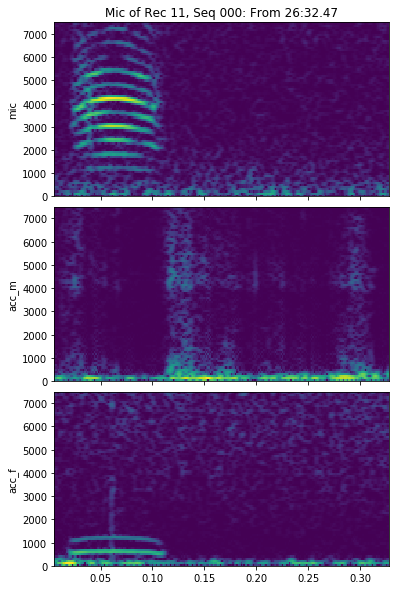

In [17]:
# Plots
for i in range(1):#(mic_bp_l.shape[0]):
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
    fig.subplots_adjust(hspace=0.06)
    
    f, t, Sxx = signal.spectrogram(mic_bp_l[i], fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                    nfft=window_size, noverlap=noverlap, scaling="spectrum")
    axs[0].pcolormesh(t, f[:81], np.log10(1e-8 + Sxx[:81,:]))
    
    f, t, Sxx = signal.spectrogram(acc_m_l[i], fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                    nfft=window_size, noverlap=noverlap, scaling="spectrum")
    axs[1].pcolormesh(t, f[:81], np.log10(1e-8 + Sxx[:81,:]))
    
    f, t, Sxx = signal.spectrogram(acc_f_l[i], fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                    nfft=window_size, noverlap=noverlap, scaling="spectrum")
    axs[2].pcolormesh(t, f[:81], np.log10(1e-8 + Sxx[:81,:]))
    
    axs[0].set_ylabel('mic')
    axs[1].set_ylabel('acc_m')
    axs[2].set_ylabel('acc_f')
    s_min, s_sec = get_time(idxs[i][0])

    axs[0].set_title(f'Mic of Rec {no:02}, Seq {i:03}: From {s_min}:{s_sec:0.2f}')
    fig.savefig(f'feature_trafo_rec_{no:02}_seq_{i:03}.png',bbox_inches='tight')
    #fig.savefig(f'plotso/rec_{no:02}_seq_{i:03}.png',bbox_inches='tight')
    #plt.close(fig)
    if(i%10 == 0):
        print(f'Recording {no}: plot {i} of {mic_bp_l.shape[0]}', end="\r")
        
        
print(f'All plots saved for Recording {no}.')
#del idxs

In [13]:
# Read the manual labels, saved from the Google Sheets as a csv

all_labels = pd.read_csv('manual_label_burak.csv')
#all_labels.shape

In [14]:
# Apply  a boolean filter to extract only good sequences

is_good = ((all_labels['acc_m vocal'] == 1) | (all_labels['acc_f vocal'] == 1)) & (all_labels['acc_m radio'] == 0) & (all_labels['acc_f radio'] == 0)
good_labels = all_labels[is_good]
#good_labels.shape

In [16]:
# Extract only good sequences from the recording at hand

is_rec = good_labels['Recording'] == no
rec_labels = good_labels[is_rec]

In [18]:
# Spectograms and time series saving
size = rec_labels['Sequence'].shape[0]
mic_bp_t = np.zeros((size,idxs.shape[1]))
acc_m_t = np.zeros((size,idxs.shape[1]))
acc_f_t = np.zeros((size,idxs.shape[1]))
mic_bp_s = [] #np.zeros((size,idxs.shape[1]))
acc_m_s = [] #np.zeros((size,idxs.shape[1]))
acc_f_s = [] #np.zeros((size,idxs.shape[1]))

for j, s in enumerate(rec_labels['Sequence']):
    
    f, t, Sxx = signal.spectrogram(mic_bp_l[s], fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                    nfft=window_size, noverlap=noverlap, scaling="spectrum")
    mic_bp_t[j] = mic_bp_l[s]
    mic_bp_s.append(Sxx[:81,:])
    f, t, Sxx = signal.spectrogram(acc_m_l[s], fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                    nfft=window_size, noverlap=noverlap, scaling="spectrum")
    acc_m_t[j] = acc_m_l[s]
    acc_m_s.append(Sxx[:81,:])
    f, t, Sxx = signal.spectrogram(acc_f_l[s], fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                    nfft=window_size, noverlap=noverlap, scaling="spectrum")
    acc_f_t[j] = acc_f_l[s]
    acc_f_s.append(Sxx[:81,:])
    if(s%10 == 0):
        print(f'Recording {no}: data {s} of {size}', end="\r")

mic_bp_s = np.asarray(mic_bp_s)
acc_m_s = np.asarray(acc_m_s)
acc_f_s = np.asarray(acc_f_s)

np.save(f'data/rec_{no:02}_mic_t.npy', mic_bp_t)
np.save(f'data/rec_{no:02}_mic_s.npy', mic_bp_s)
np.save(f'data/rec_{no:02}_acc_m_t.npy', acc_m_t)
np.save(f'data/rec_{no:02}_acc_m_s.npy', acc_m_s)
np.save(f'data/rec_{no:02}_acc_f_t.npy', acc_f_t)
np.save(f'data/rec_{no:02}_acc_f_s.npy', acc_f_s)
rec_labels.to_csv(f'data/rec_{no}_labels.csv')

print(f'All data saved for Recording {no}.')
#del idxs

NameError: name 'rec_labels' is not defined

In [24]:
f[:81]

array([   0.  ,   93.75,  187.5 ,  281.25,  375.  ,  468.75,  562.5 ,
        656.25,  750.  ,  843.75,  937.5 , 1031.25, 1125.  , 1218.75,
       1312.5 , 1406.25, 1500.  , 1593.75, 1687.5 , 1781.25, 1875.  ,
       1968.75, 2062.5 , 2156.25, 2250.  , 2343.75, 2437.5 , 2531.25,
       2625.  , 2718.75, 2812.5 , 2906.25, 3000.  , 3093.75, 3187.5 ,
       3281.25, 3375.  , 3468.75, 3562.5 , 3656.25, 3750.  , 3843.75,
       3937.5 , 4031.25, 4125.  , 4218.75, 4312.5 , 4406.25, 4500.  ,
       4593.75, 4687.5 , 4781.25, 4875.  , 4968.75, 5062.5 , 5156.25,
       5250.  , 5343.75, 5437.5 , 5531.25, 5625.  , 5718.75, 5812.5 ,
       5906.25, 6000.  , 6093.75, 6187.5 , 6281.25, 6375.  , 6468.75,
       6562.5 , 6656.25, 6750.  , 6843.75, 6937.5 , 7031.25, 7125.  ,
       7218.75, 7312.5 , 7406.25, 7500.  ])

In [15]:
save_data = False
if(save_data):
    print(f'Saving data from Recording {no}')
    np.save(f'data/mic_{no:02}.npy', mic_bp_l)
    np.save(f'data/acc_m_{no:02}.npy', acc_m_l)
    np.save(f'data/acc_f_{no:02}.npy', acc_f_l)

# Old stuff

In [12]:
def getIndex(samplerate, seconds=0, minutes=0, hours=0):
    return samplerate*(seconds + minutes*60 + hours*3600)

In [37]:
%%timeit
indices = mean_pd_abs >= 1e-6

46.2 ms ± 693 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
%%timeit
c = np.where(indices)

11 ms ± 62.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
window = 2400
sq_fil = np.power(filtered_bp,2)
mean_pd_abs = pd.Series(sq_fil).rolling(window=window).mean().iloc[window-1:].values
plt.plot(mean_pd_abs)
plt.ylim([0,0.000003])

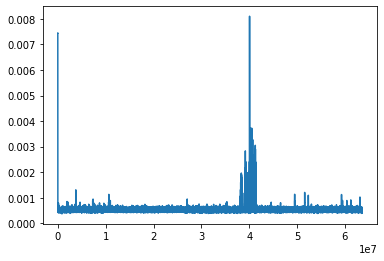

In [7]:
window = 2400
abs_fil = np.absolute(filtered_bp)
mean_pd_abs = pd.Series(abs_fil).rolling(window=window).mean().iloc[window-1:].values
plt.plot(mean_pd_abs)

In [22]:
%%time
counter = 0

mic_bp_sht = []
acc_m_sht = []
acc_f_sht = []

for i, j in enumerate(mean_pd_abs):
    if j >= 2e-6:
        mic_bp_sht.append(filtered_bp[i + window//2])
        acc_m_sht.append(acc_m[i + window//2])
        acc_f_sht.append(acc_f[i + window//2])
        counter += 1
        
print(counter)
mic_bp_np = np.asarray(mic_bp_sht)
acc_m_np = np.asarray(acc_m_sht)
acc_f_np = np.asarray(acc_f_sht)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/old2_11_short_{window}_mic_.w64', mic_bp_np, fs)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/old2_11_short_{window}_acc_m.w64', acc_m_np, fs)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/old2_11_short_{window}_acc_f.w64', acc_f_np, fs)

262687
CPU times: user 15.4 s, sys: 61 µs, total: 15.4 s
Wall time: 15.4 s


In [2]:
fs = 24000
window_size = 256
overlap = 0.875
noverlap = int(np.floor(window_size * overlap))

'''file_num = 11

filenm = f'/home/bukaya/ethz/ns/b8p2male-b10o15female_aligned/2018-08-14/b8p2male-b10o15female_{file_num}_SdrChannels.w64'
strength_filenm = f'/home/bukaya/ethz/ns/b8p2male-b10o15female_aligned/2018-08-14/b8p2male-b10o15female_{file_num}_SdrChannels.w64''''

In [3]:
with open(filenm, 'rb') as f:  
    Audiodata, _samplerate_bad = sf.read(f)
    
mic  = Audiodata[:, 0]
acc_m = Audiodata[:, 1]
acc_f = Audiodata[:, 2]
del Audiodata

In [3]:
'''for no in files:
    file = files[no]
    file = '/home/bukaya/ethz/ns/b8p2male-b10o15female_aligned/' + file
    with open(file, 'rb') as f:  
        Audiodata, _samplerate_bad = sf.read(f)
    mic   = Audiodata[:, 0]
    acc_m = Audiodata[:, 1]
    acc_f = Audiodata[:, 2]
    del Audiodata
    print(no)'''

"for no in files:\n    file = files[no]\n    file = '/home/bukaya/ethz/ns/b8p2male-b10o15female_aligned/' + file\n    with open(file, 'rb') as f:  \n        Audiodata, _samplerate_bad = sf.read(f)\n    mic   = Audiodata[:, 0]\n    acc_m = Audiodata[:, 1]\n    acc_f = Audiodata[:, 2]\n    del Audiodata\n    print(no)"

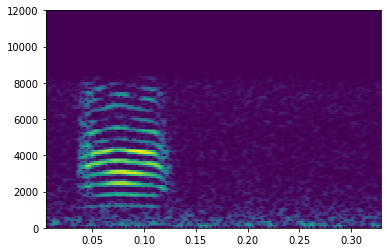

In [89]:
# Plot whole non-silence microphone
window_size = 240

f, t, Sxx = signal.spectrogram(mic_bp_l[55], fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")

#plt.pcolormesh(t, f[:80], 20 * np.log10(1 + Sxx[:80,:]))
plt.pcolormesh(t, f, np.log10(1e-8 + Sxx))

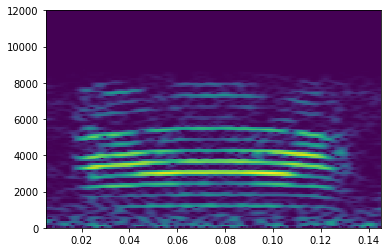

In [40]:
# Plot only a certain slice from microphone(here) and accelerometers(next)
window_size = 240
slc = slice(int(7.98*fs),int(8.13*fs))
f, t, Sxx = signal.spectrogram(mic_bp_np[slc], fs , window=signal.hann(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")

#plt.pcolormesh(t, f[:80], 20 * np.log10(1 + Sxx[:80,:]))
plt.pcolormesh(t, f, np.log10(1e-8 + Sxx))

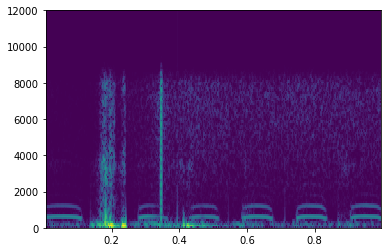

In [14]:
f, t, Sxx = signal.spectrogram(acc_f_np[slc], fs , window=signal.hann(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")

plt.pcolormesh(t, f, np.log10(1e-8 + Sxx))

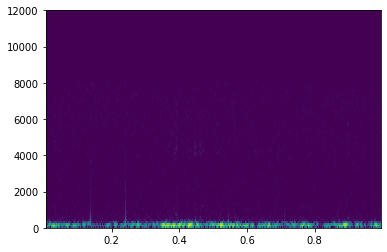

In [15]:
f, t, Sxx = signal.spectrogram(acc_m_np[slc], fs , window=signal.hann(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")
plt.pcolormesh(t, f, np.log10(1e-8 + Sxx))

In [202]:
# Save data from all sources at the same time indices
mic_bp_np = filtered_bp[indices]
acc_m_np  = acc_m_bp[indices]
acc_f_np  = acc_f_bp[indices]
acc_f_nf = acc_f[indices]
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/{no}_{window}_mic.w64', mic_bp_np, fs)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/{no}_{window}_acc_m.w64', acc_m_np, fs)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/{no}_{window}_acc_f.w64', acc_f_np, fs)